In [5]:
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.wcs import WCS
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.units as u

%matplotlib inline

### Plot configuration

In [6]:
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14
#Improve plots resolution
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

### Files

In [7]:
image_h = "MIGHTEE_Continuum_DR1_CDFS-DEEP_5p5arcsec_I_v1-Copy1.fits"
image_l = "MIGHTEE_Continuum_DR1_CDFS-DEEP_7p3arcsec_I_v1-Copy1.fits"
#Candels catalogs
catalog_m = "hlsp_candels_hst_wfc3_goodss_santini_v1_mass-cat.fits" #Positions,flags,redshifts,stellar masses
catalog_p = "hlsp_candels_hst_wfc3_goodss_santini_v1_physpar-cat.fits" #Physical parameters


### Fits info

In [8]:
#gives .fits information
def info(file):
    hdulist = fits.open(file,memmap = True)
    #give information about the file
    info = hdulist.info()
    
    hdulist.close()
    return(info)

# gives .fits header back from index 0
def header0(file):
    hdulist = fits.open(file, memmap = True)
    hdr0 = hdulist[0].header
    
    hdulist.close()
    return(hdr0)

### Plot histogram

In [9]:
#GET IMAGE DATA
#Get image data ready to use for histogram plotting

def image_data(image):
    
    image_data = fits.getdata(image)
    ax2_data = image_data[0,0,:,:]#take only the 2 needed axis on the image
    data = ax2_data.flatten()#flatten numpy array to use data in histogram
    data=data[np.isnan(data)==False]#Take out white pixels from the image
    return(data)

In [10]:
#High resolution image
x_h = image_data(image_h)
#Low resolution image
x_l = image_data(image_l)

#Data for histogram without nan pixels and in microJy
data_h = x_h[np.isnan(x_h)==False]*1.e6
data_l = x_l[np.isnan(x_l)==False]*1.e6
bins = np.linspace(-13,35., 161)

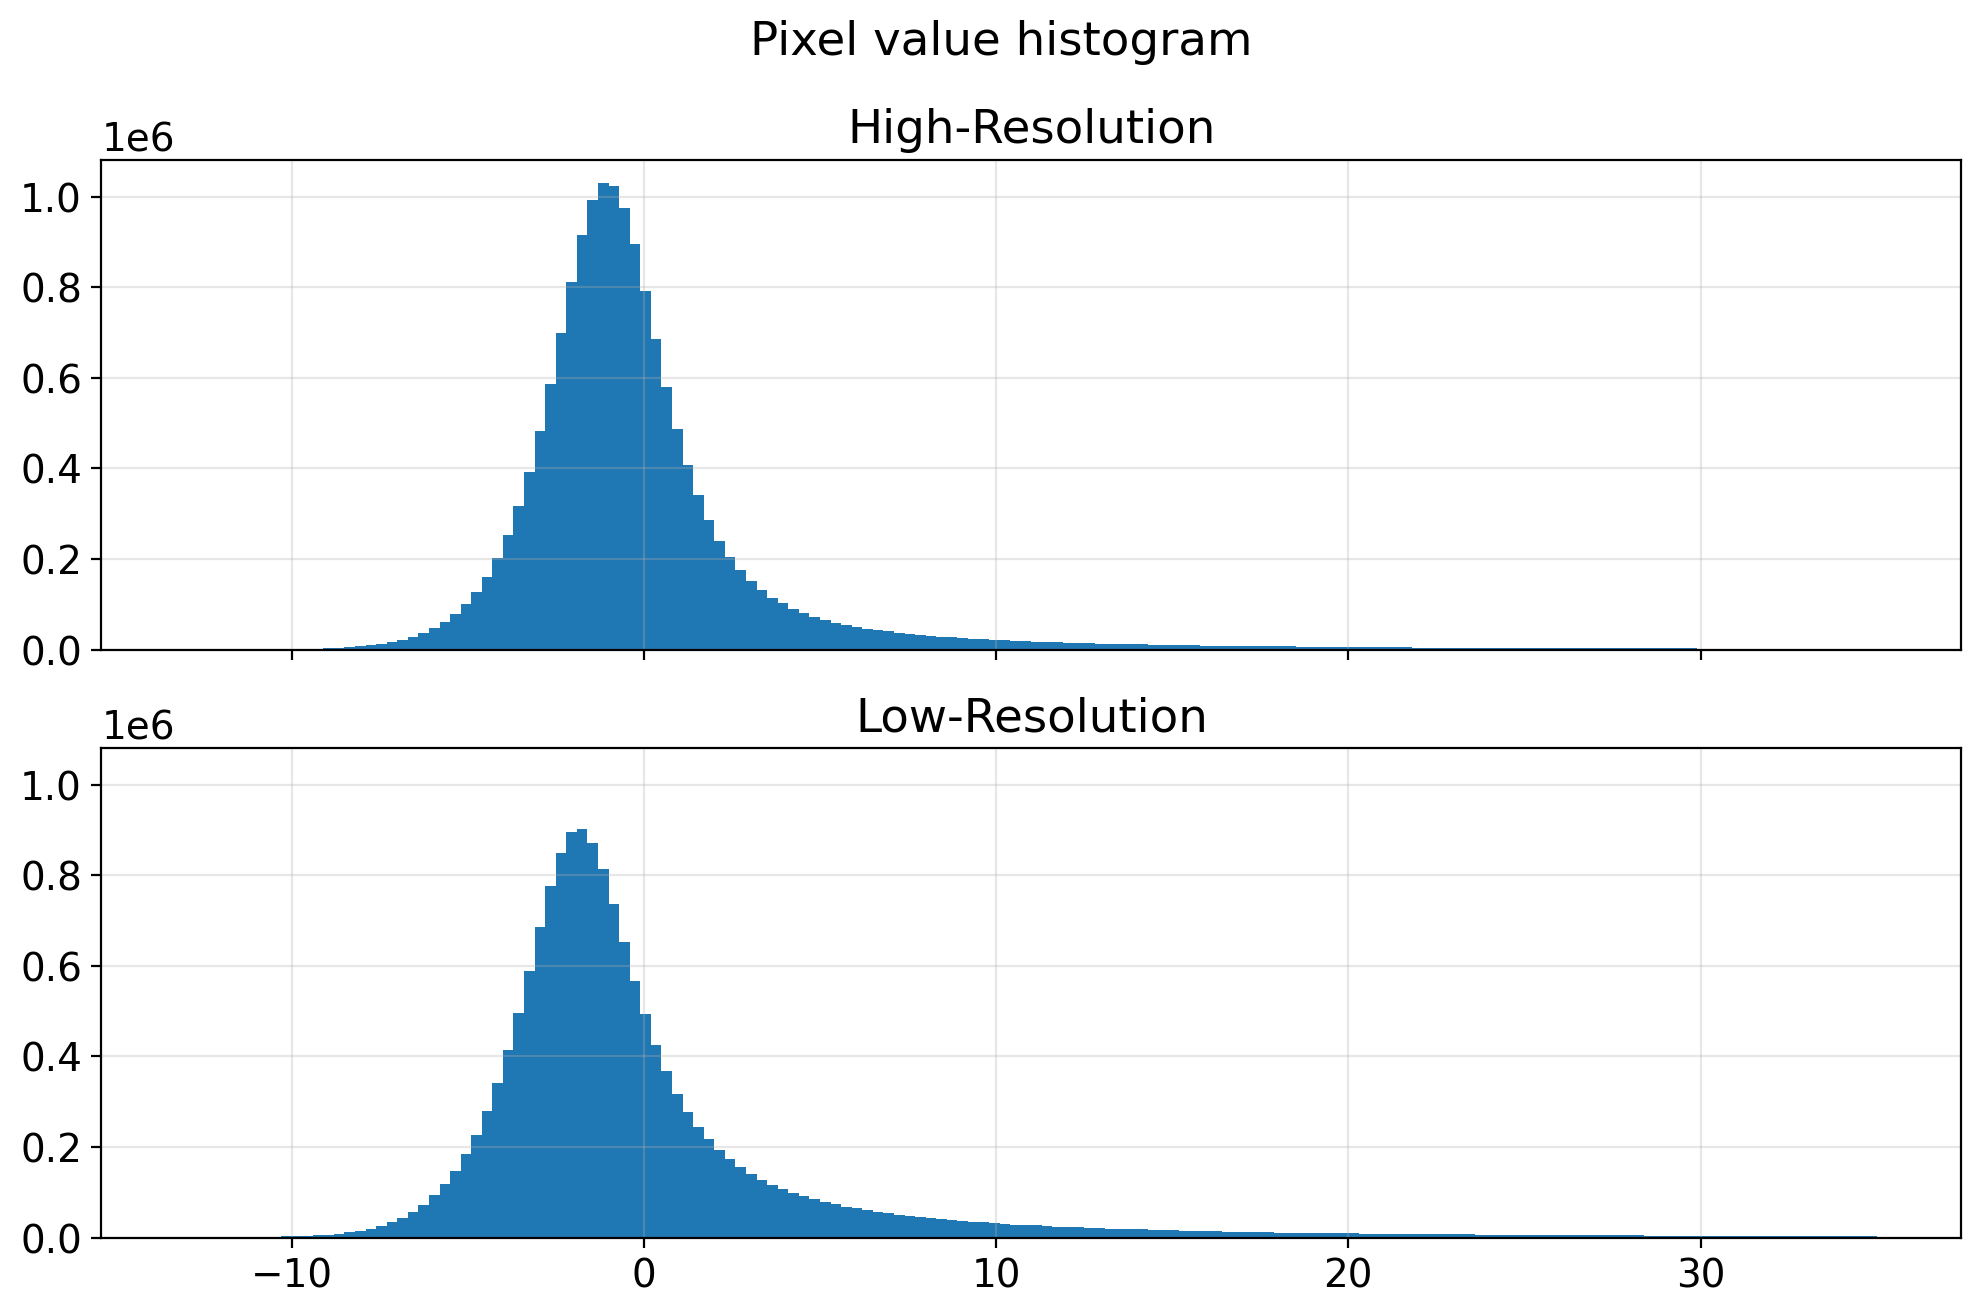

In [11]:
#Plot histogram 
fig,axs = plt.subplots(2,1,sharey = True , sharex = True)
fig.suptitle("Pixel value histogram")#Frequency distribution

axs[0].hist(data_h, bins )#Data in micro Jy
axs[1].hist(data_l, bins)#Data in micro Jy


axs[0].set_title("High-Resolution")
axs[1].set_title("Low-Resolution")

axs[0].grid(which="both",alpha = 0.3)
axs[1].grid(which="both",alpha = 0.3)

In [12]:
#Stats parameters to fit Gaussian into data (above histograms)

def stats_parameters(data):
    mean = data.mean()
    std=data.std()
    return(mean,std)

stats_parameters(data_h)

(3.8133454, 185.97609)

In [13]:
def gaussian(x,mean,amplitude,std):
    return np.power(10,amplitude)*np.exp(- (x - mean)**2/ (2*std** 2))

[-1.81504282  5.94207268  1.70905701]


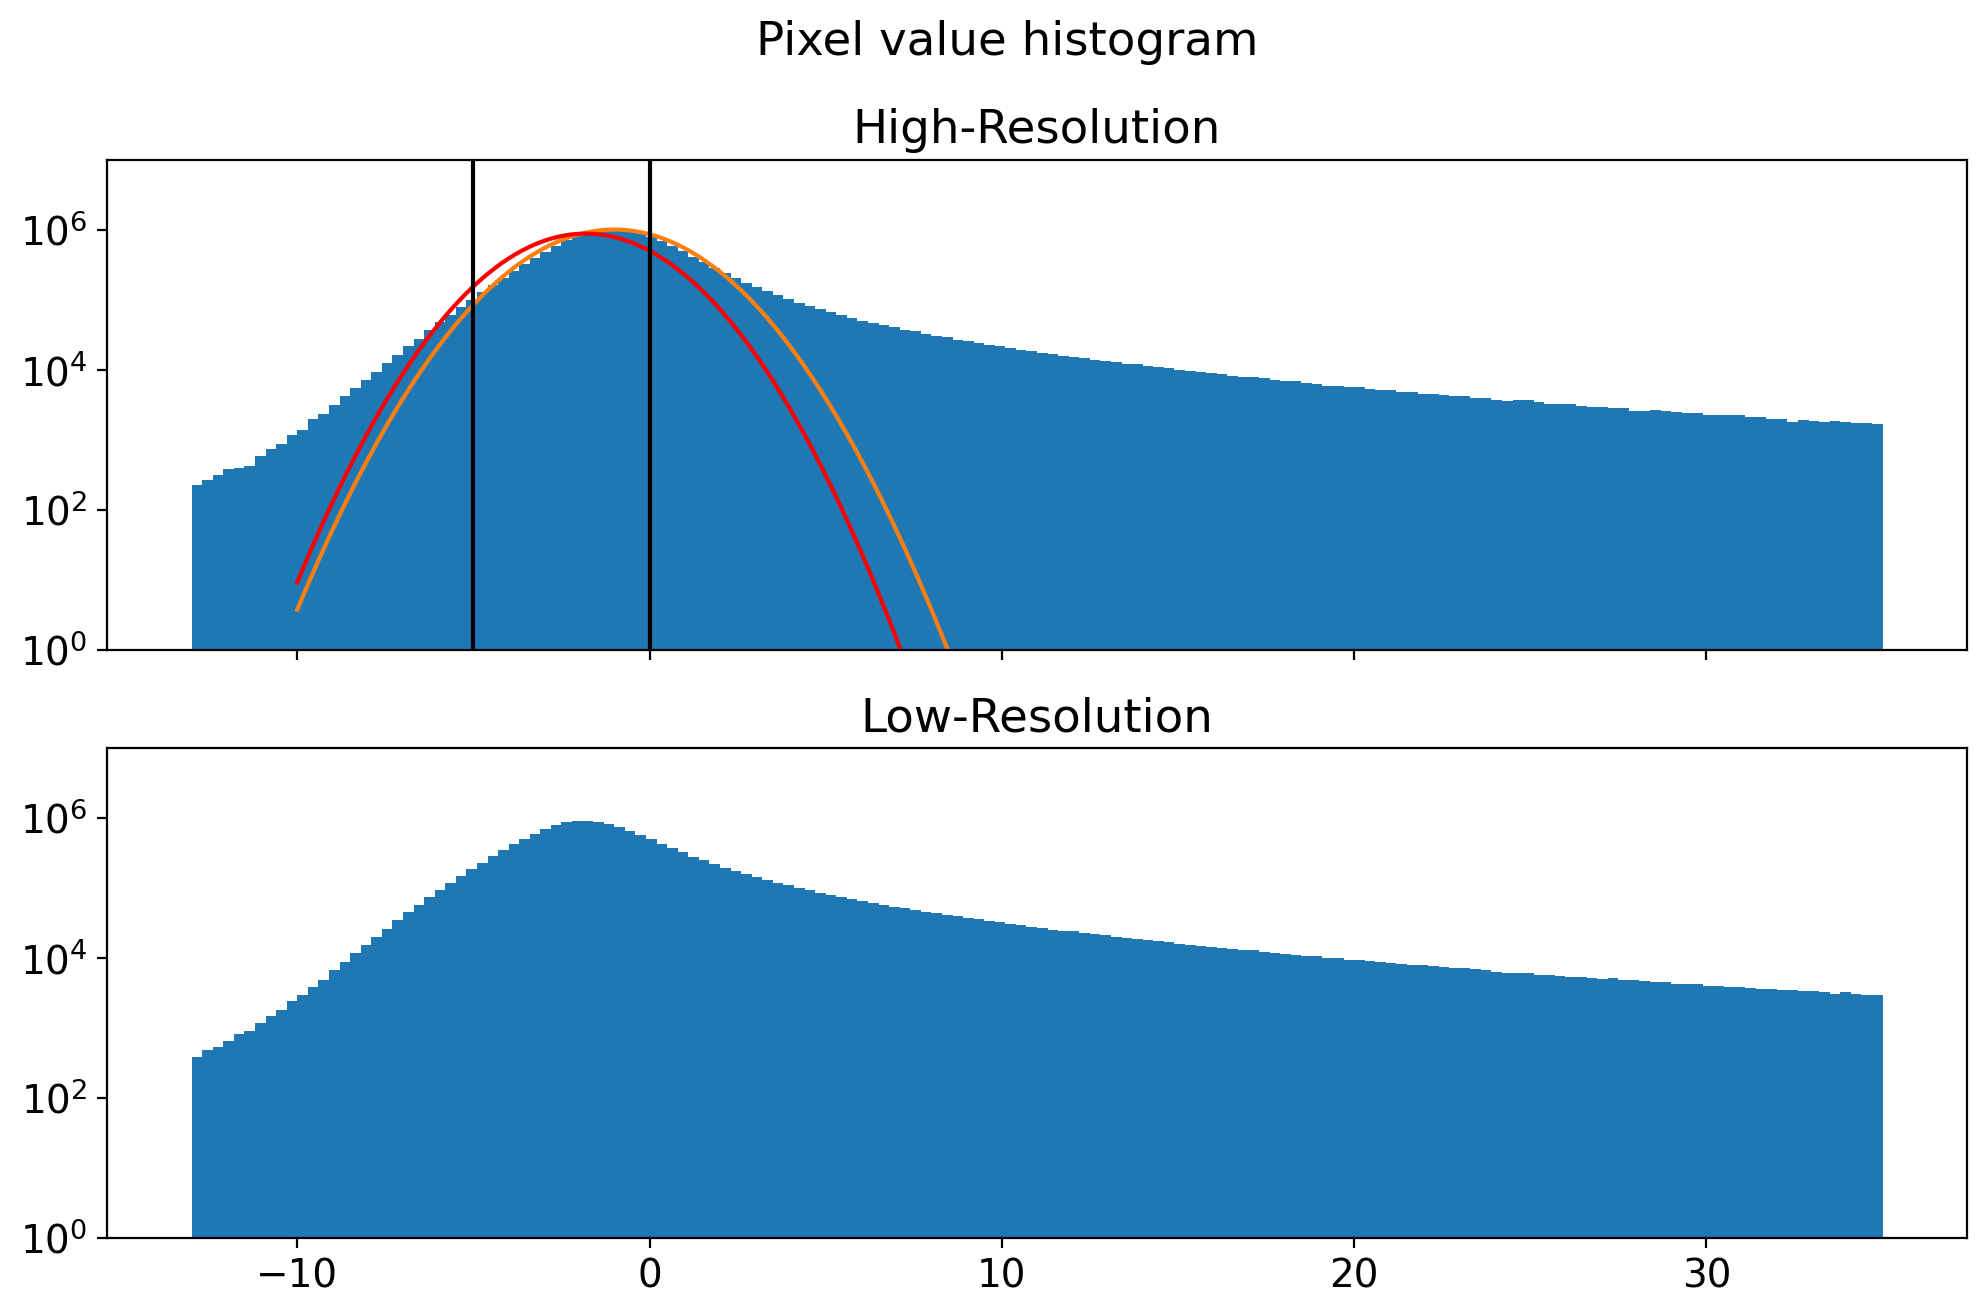

In [14]:
#Plot histogram 
fig,axs = plt.subplots(2,1,sharey = True , sharex = True)
fig.suptitle("Pixel value histogram")#Frequency distribution

hist_h= axs[0].hist(data_h, bins )#Data in micro Jy
hist_h=axs[1].hist(data_l, bins)#Data in micro Jy


axs[0].set_title("High-Resolution")
axs[1].set_title("Low-Resolution")

flux =np.linspace(-10,20,151)
y_model = gaussian(flux,-1,6,1.8)
axs[0].plot(flux,y_model)

mid_bin_h = (hist_h[1][:-1] + hist_h[1][1:])/2
popt, pcov = curve_fit(gaussian, mid_bin_h[(mid_bin_h<0) & (mid_bin_h>-5)], hist_h[0][(mid_bin_h<0) & (mid_bin_h>-5)], sigma =np.sqrt(hist_h[0][(mid_bin_h<0) & (mid_bin_h>-5)]))

y_model_fit = gaussian(flux,popt[0],popt[1],popt[2])
axs[0].plot(flux,y_model_fit, c = "r")

print(popt)
axs[0].set_yscale("log")
axs[0].set_ylim(1.e0, 1.e7)

axs[0].axvline(-5., color="k")
axs[0].axvline(0., color="k")


In [15]:
#FITS FILE AND HEADER INFORMATION

#gives .fits information
def info(file):
    hdulist = fits.open(file,memmap = True)
    #give information about the file
    info = hdulist.info()
    
    hdulist.close()
    return(info)

# gives .fits header back from index 0
def header0(file):
    hdulist = fits.open(file, memmap = True)
    hdr0 = hdulist[0].header
    
    hdulist.close()
    return(hdr0)

# gives .fits header back from index 1
def header1(file):
    hdulist = fits.open(file, memmap = True)
    hdr1 = hdulist[1].header
    
    hdulist.close()
    return(hdr1)

#Returns Table with survey information
def table(file) :
    hdul = fits.open(file, memmap = True)
    hdul_data = Table(hdul[1].data)
    
    hdulist.close()
    return (hdul_data)

In [16]:
t = Table.read(catalog_m)
t2 = Table.read(catalog_p)
print(len(t), len(t2))

34930 34930


In [17]:
#GET RMS FROM RADIO CATALOGUE

#Gets data from desire column and returns it in numpy format
def get_data(catalogue,colum):
    hdulist = fits.open(catalogue, memmap = True)
    table_data = hdulist[1].data[colum]
    np_data = np.array(table_data)
    
    hdulist.close()
    return(np_data)

In [18]:
#COMPUTE IMAGE RMS FOR EACH SOURCE ON MIGHTEE IMAGE

#convert RA and DEC coordinates into pixel positions
def convert(file,catalogue, racol, deccol):
    
    hdul = fits.open(file)
    #extract wcs info from header
    wcs = WCS(hdul[0].header)

    #create arrays for information about RA and DEC coordinates
    ra = get_data(catalogue,racol)
    dec = get_data(catalogue,deccol)
    
    #px=pixels position corresponding to RA
    #py=pixel position corresponding to DEC
    px,py,_,_ = wcs.all_world2pix(ra,dec,0,0,1)
    
    hdul.close()
    return(px,py)

#Get pixel values for each source
def pix_val(file,catalogue, racol, deccol):
    
    #variables with pixel positions on x and y
    px_val =convert(file,catalogue, racol,deccol)[0]
    py_val =convert(file,catalogue, racol,deccol)[1]
    
    #Load image
    hdul = fits.open(file)
    values = []
    
    #get pixel value at every x position and create array with results
    for i,j in zip(px_val,py_val):
        #get data from fits
        file_data = hdul[0].data
        #pixel data at each specific position
        val_pix = file_data[0,0,int(j),int(i)] #uses int for pixel positions
        values.append(val_pix)
    
    #array with all sources pixel values    
    final=np.array(values)
    
    hdul.close()
    return(final)

#compute rms for each source on image
def image_rms(file,catalogue, racol, deccol):
    
    list_rms = []
    pv = pix_val(file,catalogue, racol, deccol)
    
    #itinerate over each pixel value to compute rms
    for p in pv:
        #step1:squared of pixel value corresponding to source
        p_sqrt = np.square(p)
        #step2:mean of squared value calculated(will retrieve the same value because only 1 pixel)
        m_sqrt = np.mean(p_sqrt)
        #step3:squared root of mean squared
        rms = np.sqrt(m_sqrt)
        #list with all image_rms 
        list_rms.append(rms)

    image_rms = np.array(list_rms)
    
    return(image_rms)

#### Flux using Candles  catalogue

In [19]:
#Map position on Candels Catalogue and used them to get flux on sources positions
posi_h = pix_val(image_h,catalog_m,"RAdeg","DECdeg")*1e6 #Flux in microJy
posi_l = pix_val(image_l,catalog_m,"RAdeg","DECdeg")*1e6 #Flux in microJy
print(posi_h)

[ 6.947449    2.0897558  -0.65302414 ...  3.0461342  -1.9336158
  2.1285846 ]


[-1.81504282  5.94207268  1.70905701]


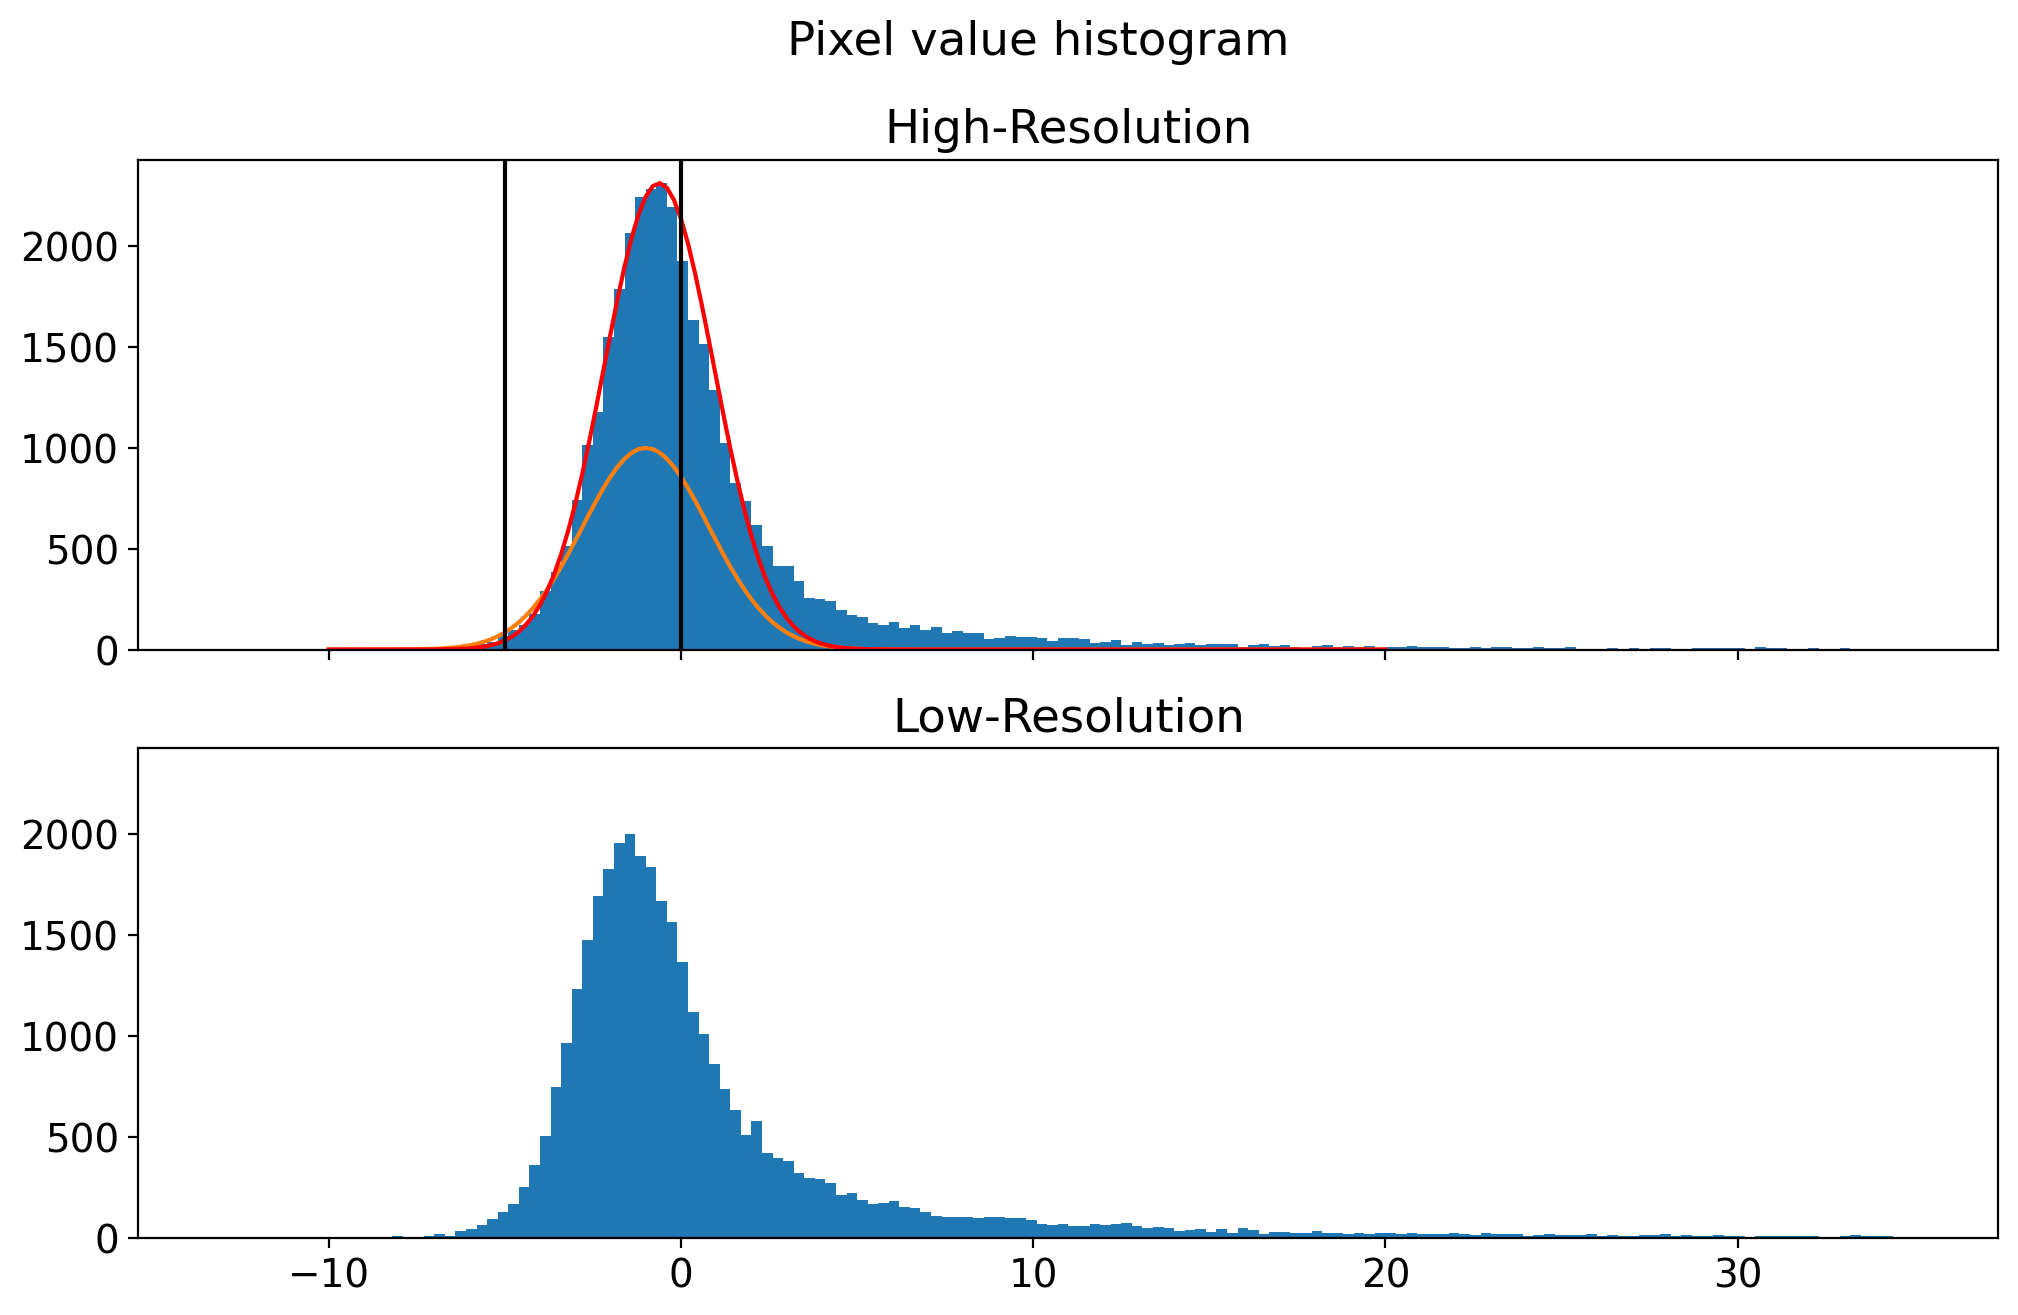

In [20]:
#Plot histogram 
fig,axs = plt.subplots(2,1,sharey = True , sharex = True)
fig.suptitle("Pixel value histogram")#Frequency distribution

hist_h_val= axs[0].hist(posi_h, bins )#Data in micro Jy
hist_l_val=axs[1].hist(posi_l, bins)#Data in micro Jy


axs[0].set_title("High-Resolution")
axs[1].set_title("Low-Resolution")

flux =np.linspace(-10,20,151)
y_model = gaussian(flux,-1,3,1.8)
axs[0].plot(flux,y_model)

mid_bin_h_val = (hist_h_val[1][:-1] + hist_h_val[1][1:])/2
popt_val, pcov_val = curve_fit(gaussian, mid_bin_h_val[(mid_bin_h_val<0) & (mid_bin_h_val>-5)], hist_h_val[0][(mid_bin_h_val<0) & (mid_bin_h_val>-5)], sigma =np.sqrt(hist_h_val[0][(mid_bin_h_val<0) & (mid_bin_h_val>-5)]))

y_model_fit = gaussian(flux,popt_val[0],popt_val[1],popt_val[2])
axs[0].plot(flux,y_model_fit, c = "r")

print(popt)
#axs[0].set_yscale("log")
#axs[0].set_ylim(1.e0, 1.e7)

axs[0].axvline(-5., color="k")
axs[0].axvline(0., color="k")


In [21]:
hist_h
print(hist_h)
print(len(hist_h[0]), len(hist_h[1]))

(array([3.80000e+02, 4.79000e+02, 5.26000e+02, 6.37000e+02, 8.13000e+02,
       9.01000e+02, 1.15000e+03, 1.44000e+03, 1.80800e+03, 2.36000e+03,
       2.94800e+03, 3.85400e+03, 4.82700e+03, 6.62300e+03, 8.66900e+03,
       1.14820e+04, 1.52040e+04, 1.99830e+04, 2.59380e+04, 3.42740e+04,
       4.42230e+04, 5.69000e+04, 7.26990e+04, 9.31190e+04, 1.17242e+05,
       1.47411e+05, 1.83787e+05, 2.26587e+05, 2.79948e+05, 3.41715e+05,
       4.13877e+05, 4.96912e+05, 5.89551e+05, 6.84885e+05, 7.75300e+05,
       8.50203e+05, 8.95553e+05, 9.01726e+05, 8.72300e+05, 8.12758e+05,
       7.36232e+05, 6.51923e+05, 5.67513e+05, 4.93198e+05, 4.25269e+05,
       3.66787e+05, 3.17994e+05, 2.77452e+05, 2.44631e+05, 2.16630e+05,
       1.93153e+05, 1.73589e+05, 1.55459e+05, 1.41135e+05, 1.27758e+05,
       1.16770e+05, 1.07424e+05, 9.88780e+04, 9.13600e+04, 8.43680e+04,
       7.85440e+04, 7.37930e+04, 6.84680e+04, 6.43520e+04, 6.03290e+04,
       5.68380e+04, 5.34510e+04, 5.07080e+04, 4.78640e+04, 4.53

In [22]:
mean = stats_parameters(data_h)[0]
std = stats_parameters(data_h)[1]
amplitude = 0

In [23]:
g = gaussian(data_h,mean,amplitude, std)

### Compute the Luminosities

In [24]:
def read_candels(catalog):
    t_r = Table.read(catalog)
    return (t_r)

read_candels(catalog_m)

Seq,RAdeg,DECdeg,Hmag,H_SNR,PhotFlag,StarFlag,Class_star,AGNFlag,zbest,zspec,q_zspec,r_zspec,zphot,zphot_l68,zphot_u68,zphot_l95,zphot_u95,zAGN,M_med,s_med,M_neb_med,s_neb_med,delta_Mz,M_2a_tau,M_2d_tau,M_6a_tau,M_10c,M_11a_tau,M_12a,M_13a_tau,M_14a,M_15a,M_6a_tau^NEB,M_6a_deltau,M_6a_invtau,M_10c^dust,M_12a_tau,M_14a_const,M_14a_lin,M_14a_deltau,M_14a_tau
int32,float64,float64,float32,float32,int16,int16,float32,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,53.0929947,-27.9545364,19.58,471.89,0,0,0.03,0,0.5303,0.5303,1,41,0.514,0.46,0.56,0.41,0.61,-99.0,27100000000.0,3880000000.0,26400000000.0,942000000.0,0.325,10.49,10.66,10.44,10.16,10.43,10.33,10.5,10.44,10.35,10.41,10.47,10.41,10.29,10.37,10.45,10.52,10.45,10.44
2,53.1028862,-27.9596615,24.99,3.71,0,0,0.51,0,1.72,-99.0,-99,-99,1.72,1.58,1.9,1.33,5.44,-99.0,9440000000.0,4770000000.0,6650000000.0,4660000000.0,0.673,10.21,10.46,9.96,10.21,9.37,9.82,9.99,9.99,10.18,10.04,9.97,9.93,10.1,9.77,9.84,9.69,9.93,9.99
3,53.1016846,-27.9584789,21.37,95.06,0,0,0.03,0,0.264,0.2341,2,112,0.264,0.18,0.35,0.1,0.42,-99.0,777000000.0,133000000.0,843000000.0,122000000.0,0.665,8.96,9.15,8.85,8.78,8.98,8.82,8.94,8.87,8.78,8.98,9.11,8.85,8.78,8.85,8.94,9.01,8.88,8.87
4,53.1022797,-27.9586506,24.07,4.1,0,0,0.01,0,0.63,-99.0,-99,-99,0.63,0.5,0.79,0.39,1.14,-99.0,611000000.0,245000000.0,430000000.0,307000000.0,2.447,8.87,9.12,8.08,8.7,8.86,8.7,8.93,8.79,8.62,8.15,8.53,8.09,8.61,8.7,8.78,8.72,8.77,8.79
5,53.0905571,-27.9584999,25.21,14.04,0,0,0.0,0,2.702,-99.0,-99,-99,2.702,2.62,2.79,2.5,3.03,-99.0,17400000000.0,5040000000.0,16800000000.0,6790000000.0,0.211,10.34,10.24,10.25,10.18,9.77,10.13,10.24,10.22,10.26,10.26,10.2,10.09,10.33,10.34,10.16,10.06,10.18,10.22
6,53.0999413,-27.9582806,23.58,21.48,0,0,0.0,0,2.924,-99.0,-99,-99,2.924,2.85,2.98,0.36,3.09,-99.0,2480000000.0,662000000.0,2490000000.0,201000000.0,0.818,9.34,9.33,9.39,9.65,9.38,9.4,9.61,9.43,9.33,9.36,9.41,9.39,9.65,9.37,9.54,9.43,9.44,9.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34924,53.1285858,-27.6785259,26.8,5.23,0,0,0.75,0,0.59,-99.0,-99,-99,0.59,0.36,2.96,0.11,4.11,-99.0,20900000.0,7290000.0,19400000.0,1850000.0,1.034,7.44,7.47,6.71,8.07,7.32,7.32,7.42,7.32,7.31,7.25,7.18,6.71,8.07,7.2,7.34,7.31,7.23,7.32
34925,53.158432,-27.6765919,27.46,4.91,0,0,0.19,0,1.199,-99.0,-99,-99,1.199,0.57,1.83,0.25,2.5,-99.0,15300000.0,19100000.0,37300000.0,29800000.0,1.195,7.18,7.59,7.01,6.91,7.81,7.14,7.19,7.22,7.18,7.0,7.06,7.01,6.91,7.11,7.22,7.17,7.16,7.23


### Compute Luminosities

In [25]:
#VARIABLES
def get_variable(flux_data): #flux_data = posi_h/posi_l
    
    redshift = get_data(catalog_m,"zbest") #Redshift
    flux_da = (flux_data*1e-6)*1e-26 #convert to W m^-2 Hz^-1
    
    #Compute luminosity distance in meters
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    d_l_Mpc = cosmo.luminosity_distance(redshift) #luminosity distance in /Mpc
    d_l_m = d_l_Mpc.to(u.m) #luminosity distance in /m
    
    return(redshift,d_l_m,flux_da)

In [26]:
#High resolution image
z_h = get_variable(posi_h)[0] #Redshift
dl_h = get_variable(posi_h)[1] #Luminosity distance in m
flux_den_h = get_variable(posi_h)[2] #Flux in W m^-2 Hz^-1

#Low resolution image
z_l = get_variable(posi_l)[0] #Redshift
dl_l = get_variable(posi_l)[1] #Luminosity distance in m
flux_den_l = get_variable(posi_l)[2] #Flux in W m^-2 Hz^-1

In [27]:
#COMPUTE LUMINOSITY
def Luminosity(z,flux,lum_d):
    spec = -0.7 #spectral index
    freq_ratio = 1.4/1.3 #GHz 
    
    l = (4*np.pi*(lum_d**2)*z/(1+z)**(1+spec))*((freq_ratio)**spec)*flux
    return (l)

In [28]:
Lu_h = np.array(Luminosity(z_h,flux_den_h,dl_h))
Lu_l = np.array(Luminosity(z_l,flux_den_l,dl_l))

In [ ]:
#PLOT LUMINOSITY VS. REDSHIFT 
plt.rcParams['figure.figsize'] = (16,7)

fig,axs = plt.subplots(1,2, sharey = True, sharex = True)

axs[0].scatter(z_h, Lu_h, s=2, c="darkviolet",alpha=0.3, label= "High resolution image")
axs[0].set_yscale("log")
axs[0].legend(loc="lower right")

axs[1].scatter(z_l, Lu_l, s=2, c="cornflowerblue",alpha=0.3, label = "Low resolution image")
axs[1].set_yscale("log")
axs[1].legend(loc="lower right")

axs[0].set_ylabel("Luminosity/ W Hz^-1")
axs[0].set_xlabel("Redshift")
#axs[1].set_ylabel("Luminosity/ W Hz^-1")
axs[1].set_xlabel("Redshift")

fig.suptitle("Luminosity vs. Redshift")
fig.tight_layout()
#plt.savefig("Luminosity_vs_Redshift.png")

### Luminosity Vs. SFR 

In [26]:
tab_candels = read_candels(catalog_p)

In [ ]:
SFR = get_data(catalog_p, "SFR_2a_tau")
plt.rcParams['figure.figsize'] = (16,6)

fig,axs = plt.subplots(1,2, sharey = True, sharex = True)

axs[0].scatter(SFR, Lu_h, s=2, c="darkviolet",alpha=0.3, label= "High resolution image")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].legend(loc="lower right")

axs[1].scatter(SFR, Lu_l, s=2, c="cornflowerblue",alpha=0.3, label = "Low resolution image")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].legend(loc="lower right")

axs[0].set_ylabel("Luminosity/ W Hz^-1")
axs[0].set_xlabel("Redshift")
#axs[1].set_ylabel("Luminosity/ W Hz^-1")
axs[1].set_xlabel("Redshift")

fig.suptitle("Luminosity vs. Redshift")
fig.tight_layout()
#plt.show()
plt.savefig("Luminosity_vs_SFR.png")


In [ ]:
SFR = get_data(catalog_p, "SFR_2a_tau")
plt.rcParams['figure.figsize'] = (16,6)

fig,axs = plt.subplots(1,2, sharey = True, sharex = True)

axs[0].scatter(SFR, Lu_h, s=2, c="darkviolet",alpha=0.3, label= "High resolution image")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].legend(loc="lower right")

axs[1].scatter(SFR, Lu_l, s=2, c="cornflowerblue",alpha=0.3, label = "Low resolution image")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].legend(loc="lower right")

axs[0].set_ylabel("Luminosity/ W Hz^-1")
axs[0].set_xlabel("Redshift")
#axs[1].set_ylabel("Luminosity/ W Hz^-1")
axs[1].set_xlabel("Redshift")

fig.suptitle("Luminosity vs. Redshift")
fig.tight_layout()
#plt.show()
plt.savefig("Luminosity_vs_SFR.png")


In [ ]:
#PLOT SFR vs. Luminosity with different models
def plot_SFR_vs_Lu(catalog):
    SFR_data =[]
    SFR_models = ["SFR_2a_tau","SFR_6a_tau","SFR_11a_tau","SFR_13a_tau","SFR_14a"]
    for m in SFR_models:
        SFR = get_data(catalog,m)

In [30]:
SFR_2atau = get_data(catalog_p, "SFR_2a_tau")
SFR_6atau = get_data(catalog_p, "SFR_6a_tau")
SFR_11atau = get_data(catalog_p, "SFR_11a_tau")
SFR_13atau = get_data(catalog_p,"SFR_13a_tau")
SFR_14atau = get_data(catalog_p,"SFR_14a_tau")

In [ ]:
plt.rcParams['figure.figsize'] = (20, 11)
fig,axs = plt.subplots(5,2,sharey = True, sharex = True)

axs[0,0].scatter(SFR_2atau, Lu_h, s=2, c="darkviolet",alpha=0.3, label= "High resolution image")
axs[0,0].set_yscale("log")
axs[0,0].set_xscale("log")
axs[0,0].legend(loc="lower right")

axs[0,1].scatter(SFR_2atau, Lu_l, s=2, c="darkviolet",alpha=0.3, label = "Low resolution image")
axs[0,1].set_yscale("log")
axs[0,1].set_xscale("log")
axs[0,1].legend(loc="lower right")

axs[1,0].scatter(SFR_6atau, Lu_h, s=2, c="g",alpha=0.3, label= "High resolution image")
axs[1,0].set_yscale("log")
axs[1,0].set_xscale("log")
axs[1,0].legend(loc="lower right")

axs[1,1].scatter(SFR_6atau, Lu_l, s=2, c="g",alpha=0.3, label = "Low resolution image")
axs[1,1].set_yscale("log")
axs[1,1].set_xscale("log")
axs[1,1].legend(loc="lower right")

axs[2,0].scatter(SFR_11atau, Lu_h, s=2, c="orange",alpha=0.3, label= "High resolution image")
axs[2,0].set_yscale("log")
axs[2,0].set_xscale("log")
axs[2,0].legend(loc="lower right")

axs[2,1].scatter(SFR_11atau, Lu_l, s=2, c="orange",alpha=0.3, label = "Low resolution image")
axs[2,1].set_yscale("log")
axs[2,1].set_xscale("log")
axs[2,1].legend(loc="lower right") 

axs[3,0].scatter(SFR_13atau, Lu_h, s=2, c="blue",alpha=0.3, label= "High resolution image")
axs[3,0].set_yscale("log")
axs[3,0].set_xscale("log")
axs[3,0].legend(loc="lower right")

axs[3,1].scatter(SFR_13atau, Lu_l, s=2, c="blue",alpha=0.3, label = "Low resolution image")
axs[3,1].set_yscale("log")
axs[3,1].set_xscale("log")
axs[3,1].legend(loc="lower right") 

axs[4,0].scatter(SFR_13atau, Lu_h, s=2, c="yellow",alpha=0.3, label= "High resolution image")
axs[4,0].set_yscale("log")
axs[4,0].set_xscale("log")
axs[4,0].legend(loc="lower right")

axs[4,1].scatter(SFR_13atau, Lu_l, s=2, c="yellow",alpha=0.3, label = "Low resolution image")
axs[4,1].set_yscale("log")
axs[4,1].set_xscale("log")
axs[4,1].legend(loc="lower right") 
#plt.savefig("L_vs_SFR")

In [ ]:
data_list = [("SFR_2a_tau", "darkviolet", "High resolution image"),
             ("SFR_6a_tau", "salmon", "High resolution image"),
             ("SFR_11a_tau", "cornflowerblue", "High resolution image"),
             ("SFR_13a_tau", "orange", "High resolution image")]

plt.rcParams['figure.figsize'] = (20, 11)
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

for i, (sfr, color_h, label_h) in enumerate(data_list):
    sfr_data = get_data(catalog_p, sfr)
    
    #determines row of subplot
    row = i // 2
    #determines col of subplot
    col = i % 2
    
    #plot subplot
    axs[row, col].scatter(sfr_data, Lu_h, s=2, c=color_h, alpha=0.3, label=label_h)
    axs[row, col].set_yscale("log")
    axs[row, col].set_xscale("log")
    axs[row, col].legend(loc="lower right")

#plt.savefig("L_vs_SFR")

#### SAVE DATA INTO TABLES

In [2]:
#Save data into tables
tab_candels['Flux_l_uJy']=posi_l #Save in catalog_p Flux in uJy
tab_candels['Flux_h_uJy']=posi_h #Save in "" 

tab_candels['L_l']=Lu_l #Save in catalog_p Luminosity
tab_candels['L_h']=Lu_h #""

#Add catalog_p with new colums added to colums of catalog_m with z values
tab_candels_withz=hstack([tab_candels, read_candels(catalog_m)])

NameError: name 'posi_l' is not defined

#### Variation of relationship with z

In [34]:
tab_candels_withz.write(catalog_p[:-5]+'_WithRadio.fits', overwrite=True)

In [ ]:
plt.scatter(tab_candels_withz['SFR_2a_tau'], tab_candels_withz['L_h'], s=2, c="darkviolet",alpha=0.3, label= "High resolution image")

plt.scatter(tab_candels_withz['SFR_2a_tau'][(tab_candels_withz['zbest']>=0.5) & (tab_candels_withz['zbest']>=1.0)], tab_candels_withz['L_h'][(tab_candels_withz['zbest']>=0.5) & (tab_candels_withz['zbest']>=1.0)], s=2, c="r",alpha=0.3, label= "High resolution image")

plt.loglog()

[]